
1. Signup
2. Login
3. Exit


Enter your choice:  2
Enter your UserId:  Dev12345678
Enter your password:  1234


UserId does not exist. Please sign up.

1. Signup
2. Login
3. Exit


Enter your choice:  2
Enter your UserId:  Dev8320
Enter your password:  12345678


Welcome back, Dev8320


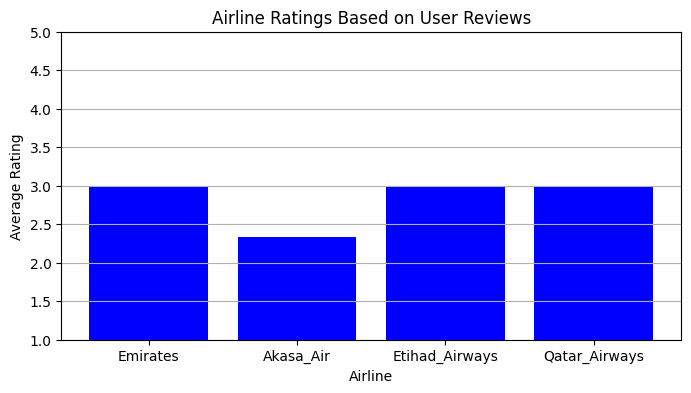


Main Menu
1. Book a flight ticket
2. See your flight ticket
3. Cancel your flight ticket
4. Logout


Enter your choice:  4


Logging out...


1. Signup
2. Login
3. Exit


Enter your choice:  3


Thank you for using our services!


In [16]:
#### import psycopg2
from datetime import datetime
import matplotlib.pyplot as plt

class DatabaseManager:
    def __init__(self):
        self.con = psycopg2.connect(host="localhost", user="postgres", password="Anagha", database="Airline")
        self.con.autocommit = False  # Allow manual commits
        self.cur = self.con.cursor()

    def execute_query(self, query, params=None, fetch_one=False, fetch_all=False, commit=False):
        try:
            self.cur.execute(query, params or ())
            
            if fetch_one:
                return self.cur.fetchone()
            if fetch_all:
                return self.cur.fetchall()
            if commit:
                self.con.commit()  # Ensure the transaction is committed
    
        except psycopg2.IntegrityError as e:
            self.con.rollback()  # Roll back the transaction to recover
            print(f"IntegrityError: {e}")
        except psycopg2.DatabaseError as e:
            self.con.rollback()  # Roll back in case of any database error
            print(f"DatabaseError: {e}")
        except Exception as e:
            self.con.rollback()
            print(f"Unexpected error: {e}")
    
    def close_connection(self):
        self.cur.close()
        self.con.close()


class User:
    def __init__(self, db_manager):
        self.db = db_manager
        self.create_users_table()

    def create_users_table(self):
        query = """
        CREATE TABLE IF NOT EXISTS users (
            user_id VARCHAR(10) PRIMARY KEY,
            password VARCHAR(10),
            name VARCHAR(50),
            phone VARCHAR(15) UNIQUE
        )
        """
        self.db.execute_query(query)
        
    def create_ratings_table(self):
        query = """
        CREATE TABLE IF NOT EXISTS rating (
            user_id VARCHAR(10),
            flight_no VARCHAR(10),
            rating INT,
            date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            PRIMARY KEY (user_id, flight_no),
            FOREIGN KEY (user_id) REFERENCES users(user_id) ON DELETE CASCADE
        )
        """
        self.db.execute_query(query)

    def verify_mobile_no(self, mobile_no):
       return mobile_no.isdigit() and len(mobile_no) == 10 and (mobile_no.startswith('9') or mobile_no.startswith('8') or mobile_no.startswith('7'))

    def sign_up(self):
        print("--------------- SignUp Page ---------------\n")

        while True:
            while True:
                try:
                    uname = input("Enter your name: ").strip()
                    if len(uname) <= 2:
                        print("Name should be more than 2 characters.")
                        continue
                    break
                except ValueError:
                    print("Invalid Input. Please try Again.")
                    continue                    

            while True:
                try:
                    mobile_no = input("Enter your Mobile number: ").strip()
                    if not self.verify_mobile_no(mobile_no):
                        print("Invalid mobile number. Please try again.")
                        continue
                    break
                except ValueError:
                    print("Invalid Input. Please try Again.")
                    continue 

            print("\nCreate your Password\nPassword length must be between 4 and 8 characters.\n")
            while True:
                try:
                    password = input("Password: ").strip()
                    if not (4 <= len(password) <= 8):
                        print("Invalid Password length. Please enter carefully.")
                        continue
                    confirm_password = input("Enter confirm password: ").strip()
                    if password != confirm_password:
                        print("Password & Confirm Password must be the same. Please enter carefully.")
                        continue
                    break
                except ValueError:
                    print("Invalid Input. Please try Again.")
                    continue 

            user_id = uname[:4] + mobile_no[:3] if len(uname) > 3 else uname[:3] + mobile_no[:4]
            if(len(user_id) >= 4):
                print("UserId consists of 1st 4 digits of your Name and 1st 3 digits of your Mobile no. (Eg: name:abcde mobileno:9876543210 password:1234 then UserId:abcd987 ")
            else:
                print("UserId consits of 1st 3 digits of your Name and 1st 4 digits of your Mobile no. (Eg: name:abc mobileno:9876543210 password:123456 then UserId: abc9876 ")
            print()

            query = "INSERT INTO users (user_id, password, name, phone) VALUES (%s, %s, %s, %s)"
            try:
                self.db.execute_query(query, (user_id, password, uname, mobile_no))
                print("User registered successfully!\nRedirecting to main menu...\n")
                self.main_menu(user_id)# Directly take user to the main menu
                break
            except psycopg2.IntegrityError:
                print("Mobile number already exists! Please use another.")
                continue

    def login(self):
        user_id = input("Enter your UserId: ").strip()
        password = input("Enter your password: ").strip()

        query = "SELECT password FROM users WHERE user_id = %s"
        result = self.db.execute_query(query, (user_id,), fetch_one=True)

        if not result:
            print("UserId does not exist. Please sign up.")
            return None
        elif result[0] != password:
            print("Entered password does not match.")
            return None
        else:
            print(f"Welcome back, {user_id}")
            self.collect_and_plot_ratings(user_id)
            self.main_menu(user_id)
            return user_id

    def get_airline_from_file(self, flight_no):
        try:
            with open("flight.txt", "r") as file:
                r1 = file.readlines()
                for line in r1:
                    parts = line.strip().split()
                    if parts[0] == flight_no:
                        return parts[1]  # Assuming airline is the second column
        except FileNotFoundError:
            print("Error: flight.txt not found.")
        return None

    def collect_and_plot_ratings(self, user_id):
        past_flights = self.db.execute_query("SELECT flight_no FROM bookings WHERE user_id = %s", (user_id,), fetch_all=True)
        if not past_flights:
            print("You havn't booked any tickets yet")
            return
        past_flights = [row[0] for row in past_flights]
        airline = None

        for flight_no in past_flights:
            airline = self.get_airline_from_file(flight_no)
            
            if airline:
                existing_rating = self.db.execute_query("SELECT rating FROM rating WHERE user_id = %s AND flight_no = %s", (user_id, flight_no), fetch_one=True)
                
                if not existing_rating:
                    while True:
                        try:
                            rating = int(input(f"Rate your experience for {airline} (1-5): "))
                            if 1 <= rating <= 5:
                                self.db.execute_query("INSERT INTO rating (user_id, flight_no, rating) VALUES (%s, %s, %s)", (user_id, flight_no, rating), commit=True)
                                break
                            else:
                                print("Please enter a rating between 1 and 5.")
                        except ValueError:
                            print("Invalid input. Please enter a number between 1 and 5.")
        
        self.plot_ratings(airline)

    def plot_ratings(self,airl):
        airlines = ["Emirates", "Akasa_Air", "Etihad_Airways", "Qatar_Airways"]
        ratings = {airline: 3 for airline in airlines}  # Default rating is 3

        for airline in airlines:
            avg_rating = self.db.execute_query("""
                SELECT AVG(r.rating) FROM rating r JOIN bookings b ON r.flight_no = b.flight_no;
            """, fetch_one=True)
            if avg_rating[0]:
                ratings[airl] = avg_rating[0]

        plt.figure(figsize=(8, 4))
        plt.bar(ratings.keys(), ratings.values(), color='blue')
        plt.xlabel("Airline")
        plt.ylabel("Average Rating")
        plt.title("Airline Ratings Based on User Reviews")
        plt.ylim(1, 5)
        plt.grid(axis='y')
        plt.show()
            
    def main_menu(self, user_id):
        while True:
            print("\nMain Menu")
            print("1. Book a flight ticket")
            print("2. See your flight ticket")
            print("3. Cancel your flight ticket")
            print("4. Logout")

            while True:
                try:
                    choice = input("Enter your choice: ").strip()
                    break
                except ValueError:
                    print("Value Error. Invalid Input! Please Enter a number")
                    continue
            
            if choice == "1":
                Flight.booking(user_id, self.db)
            elif choice == "2":
                Flight.show(user_id,self.db)
            elif choice == "3":
                Flight.delete_ticket(user_id,self.db)
            elif choice == "4":
                print("Logging out...\n")
                break
            else:
                print("Invalid choice! Please try again.")

class Flight:
    def __init__(self, flight_no, airline, route, stops, departure, arrival, economy, business, duration, seats_available, booked):
        self.flight_no = flight_no
        self.airline = airline
        self.route = route
        self.stops = stops
        self.departure = departure
        self.arrival = arrival
        self.economy = int(economy.replace(",",""))
        self.business = int(business.replace(",",""))
        self.duration = duration
        self.seats_available = int(seats_available)
        self.booked = int(booked)
        self.booked_seats = []

    def __str__(self):
        return (f"{self.flight_no:<10} {self.airline:<15} {self.route:<25} {self.stops:<12} {self.departure:<10} {self.arrival:<10} "
                f"{self.economy:<10} {self.business:<10} {self.duration:<10} {self.seats_available:<10} {self.booked:<10}")

    def load_flights_from_file():
        flights = []
        with open("flight.txt", "r") as file:
            lines = file.readlines()
            for line in lines[1:]:  # Skip the header row
                data = line.strip().split()
                flight = Flight(*data)
                flights.append(flight)
        return flights
    
    def display_seats(flight):
        print("\nSeat Map:")
        number = flight.seats_available // 6
        k = 1
        ch = 'A'
        for i in range(1, number + 1):
            print(ch, end="  ")
            for j in range(1, 9):
                if j in (4, 5):
                    print("   ", end="")
                else:
                    seat_str = f"{k:02d}"
                    if seat_str in flight.booked_seats:
                        print("-- ", end="")
                    else:
                        print(f"{seat_str} ", end="")
                    k += 1
            ch = chr(ord(ch) + 1)
            print()
        print("\nExecutive Class Seats (E1 - E6)")
        for i in range(1, 7):
            seat_str = f"E{i}"
            if seat_str in flight.booked_seats:
                print("-- ", end="")
            else:
                print(f"{seat_str} ", end="")
        print("\n")

    
    
    def booking(user_id, db_manager):
        to_dest = {1:"DUBAI",2:"PARIS",3:"SPAIN",4:"SOUTHKOREA",5:"LONDON"}
        from_dest = {1:"AHMEDABAD",2:"NEWDELHI",3:"MUMBAI",4:"CHENNAI"}
        print()
        while(True):
            print("Which Destination do you want to go to?")
            for key, value in to_dest.items():
                print(f"{key}. {value}")
            while True:
                try:
                    n = int(input("Enter your choice:"))
                    break
                except ValueError:
                    print("Value Error. Invalid Input! Please Enter a number")
                    continue
            print()
            print("From Where do you want to Book your Flight?")
            for key, value in from_dest.items():
                print(f"{key}. {value}")
            while True:
                try:
                    m = int(input("Enter your choice:"))
                    break
                except ValueError:
                    print("Value Error. Invalid Input! Please Enter a number")
                    continue
            print()
            if (n in to_dest and m in from_dest):
                to_d = to_dest[n]
                from_d = from_dest[m]
                route = from_d + "-" + to_d
                flights = Flight.load_flights_from_file()
                filtered_flights = [f for f in flights if f.route == route]
                if not filtered_flights:
                    print("No flights available for the selected route.")
                    return
                print("Available Flights:")
                print("Flight No   Airline          Route                   Stops        Dep Time   Arr Time   Economy   Business   Duration   Seats Available   Booked")
                for flight in filtered_flights:
                    print(flight)
                break
            else:
                print("Please Enter Correct choice")
                print()
                continue

        while True:
            try:
                selected_flight_no = input("\nEnter the Flight Number to book: ").strip()
                break
            except ValueError:
                print("Value Error. Invalid Input! Please Enter flight number")
                continue
        selected_flight = next((f for f in filtered_flights if f.flight_no == selected_flight_no), None)
        
        if not selected_flight:
            print("Invalid Flight Number. Please try again.")
            return

        while True:
            while True:
                try:
                    booking_date = input("Enter the date for your booking (YYYY-MM-DD): ").strip()
                    break
                except ValueError:
                    print("Value Error. Invalid Input! Please Enter a date")
                    continue
            try:
                booking_date_obj = datetime.strptime(booking_date, "%Y-%m-%d").date()  
                today_date = datetime.today().date()  
            
                if booking_date_obj < today_date:
                    print("Booking date cannot be in the past. Please enter a valid date.")
                    continue  # Restart the loop
            
                break  # Valid date → exit loop
            except ValueError:
                print("Invalid date format! Please enter in YYYY-MM-DD format.")

        # Fetch already booked seats from the database
        query = "SELECT seat_no FROM bookings WHERE flight_no = %s AND booking_date = %s"
        booked_seats = [row[0] for row in db_manager.execute_query(query, (selected_flight_no, booking_date), fetch_all=True)]
    
        selected_flight.booked_seats = booked_seats
        
        Flight.display_seats(selected_flight)
        total_seats = flight.seats_available + 7
        while True:
            try:
                num_tickets = int(input("Enter the NUMBER OF TICKETS to book: "))
                if num_tickets <= 0:
                    print("Please enter a valid positive number!")
                else:
                    break  # Exit loop if input is valid
            except ValueError:
                print("Invalid input! Please enter a number.")
                
        if(num_tickets>0 and num_tickets<=total_seats):
            selected_seats ={}
            price = 0
            for i in range(num_tickets):
                while True:
                    while True:
                        try:
                            name=input(f"Enter Passenger name {i+1}:").upper()
                            if not name:
                                print("No null values Allowed")
                                continue
                            elif(name.isalpha()):
                                break
                        except ValueError:
                            print("Value Error. Invalid Input! Please try Again.")
                            continue
                    while True:
                        try:
                            seat = input(f"Select seat for Passenger {i+1} (e.g., 01 or E1): ").strip().upper()
                            if not name:
                                print("No null values Allowed")
                                continue
                            break
                        except ValueError:
                            print("Value Error. Invalid Input! Please try Again.")
                    seats=[]
                    for j in range(1,flight.seats_available):
                        seats.append(j)
                    print(seats)
                    execu = ["E1","E2","E3","E4","E5","E6"]
                    if (seat.startswith("E")):
                        if(seat in execu):
                            if seat in booked_seats or seat in selected_seats:
                                print("Seat is already booked. Choose another seat.")
                            else:
                                selected_seats[seat]=name
                                price += selected_flight.business
                                print("Executive seat Booked!! ")
                                break
                        else:
                            print("Invalid Seats. Enter Seats based on seat Availability")
    
                    elif (int(seat) in seats):
                        if seat in booked_seats or seat in selected_seats:
                            print("Seat is already booked. Choose another seat.")
                        else:
                            selected_seats[seat]=name
                            price += selected_flight.economy
                            print("Economy seat Booked!! ")
                            break
                    else:
                        print()
                        print("Invalid Seats. Enter Seats based on seat Availability")
                        print()
        
        total_price = price + (price * 0.18)  # Adding 18% GST
        print(f"Total Price after GST: {total_price}")
        
        Flight.payment(total_price)
        
        selected_flight.seats_available -= num_tickets
        selected_flight.booked += num_tickets
        
        for seat,name in selected_seats.items():
            db_manager.execute_query("INSERT INTO bookings (flight_no, user_id, booking_date, seat_no, passenger_name,payment) VALUES (%s, %s, %s, %s, %s,%s)",(selected_flight_no, user_id, booking_date, seat, name,total_price),commit = True)
    
        print(f"Booking successful! {num_tickets} tickets booked on flight {selected_flight.flight_no}.")
        
    def payment(total_price):
        print("\nHere total 3 types of payment methods available:\nPress 1 for Credit Card\nPress 2 for Debit Card\nPress 3 for UPI")
        while True:
            try:
                pay = int(input("Enter your choice: "))
                if pay in [1, 2, 3]:
                    break
                else:
                    print("Invalid choice, please enter a valid option.")
            except ValueError:
                print("Enter a valid input.")
    
        if pay == 1:
            while True:
                while True:
                    try:
                        credit_no = input("Enter your Credit Card number: ")
                        break
                    except ValueError:
                        print("Value Error. Invalid Input! Please Enter a number")
                        continue
                if credit_no.isdigit() and len(credit_no) == 16:
                    break
                print("Invalid Credit Card number. Must be 16 digits.")
        
        elif pay == 2:
            while True:
                while True:
                    try:
                        debit_no = input("Enter your Debit Card number: ")
                        break
                    except ValueError:
                        print("Value Error. Invalid Input! Please Enter a number")
                        continue
                if debit_no.isdigit() and len(debit_no) == 12:
                    break
                print("Invalid Debit Card number. Must be 12 digits.")
            
            while True:
                while True:
                    try:
                        debit_password = input("Enter your Debit Card Password (4 or 6 digits): ")
                        break
                    except ValueError:
                        print("Value Error. Invalid Input! Please Enter a number")
                        continue
                if debit_password.isdigit() and len(debit_password) in [4, 6]:
                    break
                print("Invalid Password. Must be 4 or 6 digits.")
    
        elif pay == 3:
            while True:
                while True:
                    try:
                        upi_id = input("Enter your UPI ID: ")
                        break
                    except ValueError:
                        print("Value Error. Invalid Input! Please Enter a number")
                        continue
                if len(upi_id) >= 5:
                    break
                print("Invalid UPI ID. Must be at least 5 characters.")
    
        print(f"You have to pay {total_price}/- to book a ticket.")
        while True:
            try:
                amount = float(input("Enter amount to pay: "))
                if amount == total_price:
                    print("Transaction successful!")
                    break
                else:
                    print("Insufficient amount, please enter the correct amount.")
            except ValueError:
                print("Enter a valid amount.")

    def show(user_id, db_manager):
        print("\nDo you want to view tickets for a specific date or all tickets?")
        print("1. Specific date")
        print("2. All tickets")

        while True:
            try:
                choice = input("Enter your choice: ").strip()
                break
            except ValueError:
                print("Value Error. Invalid Input! Please Enter a number")
                continue
        
        if choice == "1":
            while True:
                try:
                    booking_date = input("Enter the date (YYYY-MM-DD): ").strip()
                    tickets = db_manager.execute_query(
                        "SELECT flight_no, booking_date, seat_no, passenger_name FROM bookings WHERE user_id = %s AND booking_date = %s",
                        (user_id, booking_date),
                        fetch_all=True
                    )
                    break
                except ValueError:
                    print("Value Error. Invalid Input! Please Enter a number")
                    continue
                except psycopg2.Error as e:
                    print("Database Error.",e)
        elif choice == "2":
            try:
                tickets = db_manager.execute_query(
                        "SELECT flight_no, booking_date, seat_no, passenger_name FROM bookings WHERE user_id = %s",
                        (user_id,),
                        fetch_all=True
                    )
            except psycopg2.Error as e:
                print("Database Error.",e)
        else:
            print("Invalid choice.")
            return
        
        if not tickets:
            print("No tickets found for the given date!!!")
            return
        
        print("\nYour Booked Tickets:")
        print(f"{'Flight No':<15}{'Booking Date':<15}{'Seat No':<10}{'Passenger Name':<15}")
        print("-" * 55)
    
        ticket_data = []
        for ticket in tickets:
            row = f"{ticket[0]:<15}{str(ticket[1]):<15}{ticket[2]:<10}{ticket[3]:<15}"
            ticket_data.append(row)
            print(row)
    
        print("\n")
    
        # Ask if the user wants to download the ticket
        while True:
            try:
                download_choice = input("Do you want to download the ticket? (yes/no): ").strip().lower()
                break
            except ValueError:
                print("Value Error. Invalid Input. Please try again")
                
        if download_choice == "yes":
            filename = f"ticket_{user_id}.txt"
            with open(filename, "w") as file:
                file.write("Your Booked Tickets:\n")
                file.write(f"{'Flight No':<15}{'Booking Date':<15}{'Seat No':<10}{'Passenger Name':<15}\n")
                file.write("-" * 55 + "\n")
                for row in ticket_data:
                    file.write(row + "\n")
                file.write("\nThank you for booking with us!")
            
            print(f"Your ticket has been downloaded as '{filename}'.")

    def delete_ticket(user_id, db_manager):
        print("\nDo you want to delete tickets for a specific date?")
        booking_date = input("Enter the date (YYYY-MM-DD): ").strip()
    
        # Fetch available tickets for the given date along with their payments
        tickets = db_manager.execute_query(
            "SELECT flight_no, seat_no, payment FROM bookings WHERE user_id = %s AND booking_date = %s",
            (user_id, booking_date),
            fetch_all=True
        )
    
        if not tickets:
            print("No tickets found for the given date!!!")
            return
    
        print("\nYour Booked Tickets on", booking_date)
        print(f"{'Flight No':<15}{'Seat No':<10}{'Payment (₹)':<10}")
        print("-" * 40)
    
        seat_list = {}
        for ticket in tickets:
            print(f"{ticket[0]:<15}{ticket[1]:<10}{ticket[2]:<10}")
            seat_list[ticket[1]] = ticket[2]  # Store seat numbers with payment
    
        while True:  # Keep asking until the user enters a valid choice
            print("\nDo you want to delete:")
            print("1. A particular seat")
            print("2. All seats on this date")
    
            choice = input("Enter your choice: ").strip()
    
            if choice == "1":
                seat_no = input("Enter the seat number to delete: ").strip()
                if seat_no in seat_list:
                    refund_amount = seat_list[seat_no]  # Refund from stored payment
                    cancel_reason = input("Enter the reason for cancellation: ").strip()
    
                    # Delete booking from bookings table
                    db_manager.execute_query(
                        "DELETE FROM bookings WHERE user_id = %s AND booking_date = %s AND seat_no = %s",
                        (user_id, booking_date, seat_no)
                    )
    
                    # Store cancellation details
                    db_manager.execute_query(
                        "INSERT INTO cancellation (user_id, flight_no, seat_no, booking_date, refund_amount, reason) VALUES (%s, %s, %s, %s, %s, %s)",
                        (user_id, tickets[0][0], seat_no, booking_date, refund_amount, cancel_reason)
                    )
    
                    print(f"Seat {seat_no} has been deleted. Refund: ₹{refund_amount}")
                else:
                    print("Invalid seat number! Please enter a correct one.")
                break  # Exit loop after valid choice
    
            elif choice == "2":
                total_refund = sum(seat_list.values())  # Total refund for all seats
                cancel_reason = input("Enter the reason for cancellation: ").strip()
    
                # Delete all bookings for the given date
                db_manager.execute_query(
                    "DELETE FROM bookings WHERE user_id = %s AND booking_date = %s",
                    (user_id, booking_date)
                )
    
                # Store all cancellations
                for seat_no, refund_amount in seat_list.items():
                    db_manager.execute_query(
                        "INSERT INTO cancellation (user_id, flight_no, seat_no, booking_date, refund_amount, reason) VALUES (%s, %s, %s, %s, %s, %s)",
                        (user_id, tickets[0][0], seat_no, booking_date, refund_amount, cancel_reason)
                    )
    
                print(f"All seats for {booking_date} have been deleted. Total Refund: ₹{total_refund}")
                break  # Exit loop after valid choice
    
            else:
                print("Invalid choice! Please enter 1 or 2.")  # Keep asking



# Example usage
db_manager = DatabaseManager()
user_manager = User(db_manager)

while True:
    print("\n1. Signup\n2. Login\n3. Exit")
    choice = input("Enter your choice: ").strip()

    if choice == "1":
        user_manager.sign_up()
    elif choice == "2":
        user_manager.login()
    elif choice == "3":
        print("Thank you for using our services!")
        break
    else:
        print("Invalid choice! Please try again.")